# 2 Connectivity graph

## 2.1 (Mandatory) Creating the connectivity graph

In this part, we will estimate the **functional brain connectivity** obtaining the so called **connectivity graph** associated to our experiments taking into account the 64 channels and one of the following MVAR estimators:

1. Partial Directed Coherence (PDC)
1. Direct Transfer Function (DTF).

After applying this methods, we will select the matrix related to our relevant frequency value of 11 Hz so that applying a threshold we have a resulting binary matrix with a given density. Part 2.1 forces the density to 20% but we can generalize to any given density. Finally, we will plot a graphical representation of the resulting binary matrix.

### 2.1.a Creating the input matrix

In [1]:
import pyedflib
import numpy as np

def signal_matrix_from_eeg(filename):
    """
    A method to obtain the (k, N) data point matrix of signals using the pyedflib package.
    Args:
        *filename*: str
            The filename to open.
    Returns:
        *sigbufs*: np.array
            A (k, N) matrix representing k channels and N samples.
        *frequency*: int
            The sample frequency of the given data.
        *signal_labels*: [str]
            The channel labels of the given data.
    References:
    .. [1] The PyEDFlib package. To read EDF+/BDF+ files.
           http://pyedflib.readthedocs.io/en/latest/#
    """
    f = pyedflib.EdfReader(filename)
    
    k, N = f.signals_in_file, f.getNSamples()[0]
    
    sigbufs = np.zeros((k, N, 1))
    for i in np.arange(k):
        sigbufs[i, :, 0] = f.readSignal(i)
        
    return sigbufs, f.getSampleFrequency(0), f.getSignalLabels()

In [2]:
signal_38, frequency_38, names_38 = signal_matrix_from_eeg(filename='../0. Dataset/eeg_data/S038R02.edf')
names_38 = list(map(lambda x: x.replace('.',''),  names_38))
dict_names = {idx: name for idx, name in enumerate(names_38)}

### 2.1.b Obtaining the mvar model with DTF

#### 2.1.b.I Obtaining best order p

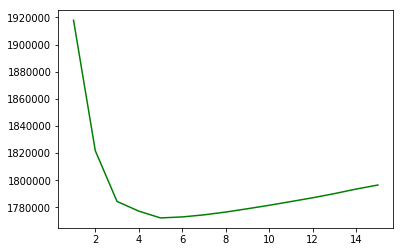

5


In [5]:
import connectivipy as cp
import matplotlib.pyplot as plt

# assign static class cp.Mvar to variable mv
mv = cp.Mvar

# find best model order using Vieira-Morf algorithm
best, crit = mv.order_akaike(signal_38, 15, 'vm')
plt.plot(1+np.arange(len(crit)), crit, 'g')
plt.show()
print(best)

#### 2.1.b.II Fitting the mvar model 

In [6]:
# Transforming matrix to connectivipy 
data_38 = cp.Data(data=signal_38, fs=frequency_38, chan_names=names_38)

# Fitting the mvar model using Yule-Walker algorithm
data_38.fit_mvar(best, 'yw')

In [9]:
dtf = cp.conn.DTF()
av, vf = data_38.mvar_coefficients
dtfval = dtf.calculate(av, vf, frequency_38)

In [93]:
significance_dft = dtf.significance(method='yw', data=av, Nrep=10, alpha=0.05)

. . . . . . . . . . |


In [7]:
pdc = cp.conn.PDC()
av, vf = data_38.mvar_coefficients
pdcval = pdc.calculate(av, vf, frequency_38)

In [83]:
significance_dft = pdc.significance(method='yw', data=, Nrep=10, alpha=0.05)

. . . . . . . . . . |


### 2.1.c Finding the best alpha

We now create the adjacency giving the output of DFT. As we want to create a directed graph, we assume that result matrix will not be symmetric. Also, we fill the output diagonal with zeros to avoid edges $\left(i,i\right) \forall i$.

As the desired density is 0.2 we will calculate the best value in order to find this density from $64*64-64 = 64*63 = 4032$ possible edges. 

If $\displaystyle \frac{x}{4032} = 0.2 \rightarrow x = 4032*0.2 = 806.4$ 

We need to find the alpha ($\alpha$) such that the number of edges in the network is as close to 806 as possible. To do this, we implement a similar method to binary search in which we try to find the closest possible value that reach the desired density 0.2. As a result, we start our search from the space of $\alpha$ which is the interval $\left(0, 1\right)$.

Notes:

1. We assume that the need to find the closest possible alpha ($\alpha$) such that the density is **at least** 0.2. As $\displaystyle \frac{x}{4032}$ is not an integer, our algorithm stops with the closes integer $x$ such that $x>806.4$.
1. We stop when the closest integer doesn't change in 2 iterations.
1. It's possible that a density $d_l$ that denotes a lower bound such that $d_l < 0.2$ is closer to 0.2 than the output of our algorithm. However, we finding the alpha such that $d_\alpha-0.2>0$ with $d_\alpha$ denoting the density of the binary matrix using $\alpha$ threshold.

In [31]:
interest_matrix = dtfval[11, :, :].reshape((64, 64))
np.fill_diagonal(interest_matrix, 0)

In [32]:
def find_best_alpha(interest, desired_density=0.2, tol=1e-3, N=64, n_iter=100, debug=True):
    search_space = [0.0, 1.0]
    density, i = 0, 0
    best_alpha, this_alpha, best_n = -1, 0, 4096
    target = int(N*(N-1)*desired_density)
   
    if debug:
        print("Desired number of nodes: {} for desired density {}".format(target, desired_density))
    
    while best_alpha != this_alpha:
        best_alpha = this_alpha
        for alpha in np.arange(search_space[0], search_space[1], (search_space[1] - search_space[0])/100.0):
            n = len(np.where(interest > alpha)[0])
            if abs(n-target) < abs(best_n-target) and n-target>0:
                this_alpha, best_n = alpha, n
        if debug:
            print("In search_space({:0.3f},{:0.3f}) alpha: {:0.3f} best_n: {} proportion: {:0.3f}".format(search_space[0], 
                                                                                                       search_space[1], 
                                                                                                       this_alpha, 
                                                                                                       best_n, 
                                                                                                       best_n/(N*(N-1))))
        search_space[0], search_space[1] = this_alpha-tol, this_alpha+tol

    return best_alpha

In [42]:
best_alpha = find_best_alpha(interest=interest_matrix, 
                             desired_density=0.05, 
                             tol=1e-3)

Desired number of nodes: 201 for desired density 0.05
In search_space(0.000,1.000) alpha: 0.210 best_n: 211 proportion: 0.052
In search_space(0.209,0.211) alpha: 0.211 best_n: 209 proportion: 0.052
In search_space(0.210,0.212) alpha: 0.212 best_n: 205 proportion: 0.051
In search_space(0.211,0.213) alpha: 0.212 best_n: 204 proportion: 0.051
In search_space(0.211,0.213) alpha: 0.213 best_n: 203 proportion: 0.050
In search_space(0.212,0.214) alpha: 0.213 best_n: 202 proportion: 0.050
In search_space(0.212,0.214) alpha: 0.213 best_n: 202 proportion: 0.050


In [43]:
import pandas as pd
import networkx as nx

In [44]:
def create_adjacency_matrix(interest, alpha):
    return np.array(interest > alpha, dtype=np.int)

In [45]:
binary_matrix = create_adjacency_matrix(interest_matrix, best_alpha)

### (2.1.d - 2.5) Creation and topological representation of the graph

We will unify last points of 2.1 and 2.5 in one question. Creating the topological representation of the graph is setting the position of the constructor of the directed graph (DiGraph).

#### Getting position data

In [46]:
def create_position_graph(filename):    
    location = pd.read_csv(filename, sep="\t", encoding='latin-1', index_col=0)
    position_data = {label.replace('.', ''): (x, y) for label, x, y in zip(location['label'], location['x'], location['y'])}
    
    return position_data

In [47]:
position_data = create_position_graph('location_data/channel_locations.txt')

#### Creating the graph

In [48]:
def create_edges_list(input_matrix, alpha):
    x, y = np.where(interest_matrix > best_alpha)
    
    return list(zip(map(lambda idx: dict_names[idx], x), map(lambda idy: dict_names[idy], y)))

def create_directed_graph(input_matrix, alpha, position):
    G = nx.DiGraph()
    G.add_nodes_from(position_data.keys(), style='filled',fillcolor='red', pos=position, nodesize=10)
    G.add_edges_from(create_edges_list(input_matrix, alpha))
    
    return G

In [49]:
directed_graph = create_directed_graph(input_matrix=interest_matrix,
                                       alpha=best_alpha,
                                       position=position_data)

#### Topological representation

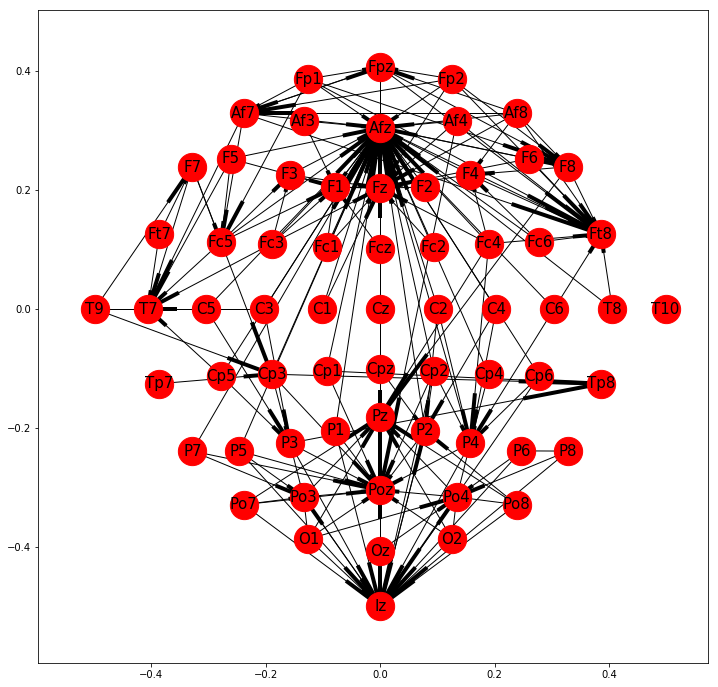

In [50]:
plt.figure(figsize=(12,12)) 
nx.draw_networkx(directed_graph, position_data, node_size=800, font_size=15)
plt.show()

### 2.1.e Drawing the adjacency matrix

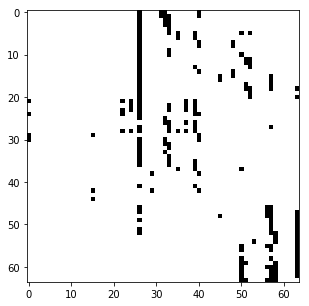

In [51]:
fig = plt.figure(figsize=(5, 5)) # in inches
plt.imshow(binary_matrix,
              cmap="Greys",
              interpolation="none")
plt.show()